# Read in Data and get setup for working

In [1]:
import numpy as np
import scipy.stats as stats
import scipy.stats as scs
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-dark')

In [2]:
beer_totals = pd.read_csv(
    'data/minor_beers.csv', 
    delimiter=","
)
beer_totals['name'] = beer_totals['Line Item']
beer_totals.set_index('name', inplace=True)
beer_totals.drop("Unnamed: 0", axis = 1, inplace=True)
print(beer_totals.shape)
beer_totals.head(3)

(40, 11)


Line Item    Cost   Price  Quantity  Modifiers  \
name                                                                            
Mississipecan Brown  Mississipecan Brown  170.85  1530.0     399.0      49.25   
Pistachio                      Pistachio  227.55  1265.5     308.0     228.80   
Festivus Ale                Festivus Ale  163.20  1254.0     301.0      36.75   

                     Subtotal  Discounts  Net Total  Tax  Total Due  \
name                                                                  
Mississipecan Brown   2443.25     106.66    2336.59  0.0    2336.59   
Pistachio             2136.80     119.47    2017.33  0.0    2017.33   
Festivus Ale          1752.75     131.88    1620.87  0.0    1620.87   

                     Customer ID  
name                              
Mississipecan Brown   3752722093  
Pistachio             2903274200  
Festivus Ale          3216682866

In [3]:
def zerolistmaker(n):
    listofzeros = [0] * n
    return listofzeros

In [4]:
beer_sales = pd.read_csv(
    'data/minor_beer_sales.csv', 
    delimiter=","
)
beer_sales.set_index("Time", inplace=True)
beer_sales["Time"] = beer_sales["Time2"]

beer_sales["datetime"] = pd.to_datetime(beer_sales["Time"])
beer_sales["datetime_hour"] = pd.DatetimeIndex(beer_sales['Time']).round("h")
beer_sales['year'] = pd.DatetimeIndex(beer_sales['datetime']).to_period("Y")
beer_sales['week'] = pd.DatetimeIndex(beer_sales['datetime']).to_period("w")

cols_to_drop = ["Time.1", "Time2", ]

beer_sales['name'] = beer_sales['Line Item'] + " " + beer_sales['year'].astype('str')
beer_sales.drop(cols_to_drop, inplace=True, axis=1)
print(beer_sales.shape)
beer_sales.head(3)

(4405, 19)


Line Item  Cost  Price  Quantity  Modifiers  \
Time                                                                         
2020-01-01 00:54:00  Mississipecan Brown  0.67    6.0       5.0        0.0   
2020-01-01 00:18:00  Mississipecan Brown  0.67    6.0       1.0        0.0   
2020-01-01 00:16:00  Mississipecan Brown  0.67    6.0       1.0        0.0   

                     Subtotal  Discounts  Net Total  Tax  Total Due  \
Time                                                                  
2020-01-01 00:54:00      30.0        0.0       30.0  0.0       30.0   
2020-01-01 00:18:00       6.0        0.0        6.0  0.0        6.0   
2020-01-01 00:16:00       6.0        3.0        3.0  0.0        3.0   

                                           Transaction ID  Customer ID  \
Time                                                                     
2020-01-01 00:54:00  C806F59B-13E5-4551-8AA8-AAE11F0914DC     13685111   
2020-01-01 00:18:00  40992540-7C50-46C9-89B2-90CB0E1C630A     13685111   
2020-01-01 00:16:00  C9EC9193-D293-4CA4-9C16-5025FC750817     13685111   

                               time_hour                 Time  \
Time                                                            
2020-01-01 00:54:00  2020-01-01 01:00:00  2020-01-01 00:54:00   
2020-01-01 00:18:00  2020-01-01 00:00:00  2020-01-01 00:18:00   
2020-01-01 00:16:00  2020-01-01 00:00:00  2020-01-01 00:16:00   

                               datetime       datetime_hour  year  \
Time                                                                
2020-01-01 00:54:00 2020-01-01 00:54:00 2020-01-01 01:00:00  2020   
2020-01-01 00:18:00 2020-01-01 00:18:00 2020-01-01 00:00:00  2020   
2020-01-01 00:16:00 2020-01-01 00:16:00 2020-01-01 00:00:00  2020   

                                      week                      name  
Time                                                                  
2020-01-01 00:54:00  2019-12-30/2020-01-05  Mississipecan Brown 2020  
2020-01-01 00:18:00  2019-12-30/2020-01-05  Mississipecan Brown 2020  
2020-01-01 00:16:00  2019-12-30/2020-01-05  Mississipecan Brown 2020

## Graphing the sales of each beer, each on its own chart to get an idea of what they generally look like.

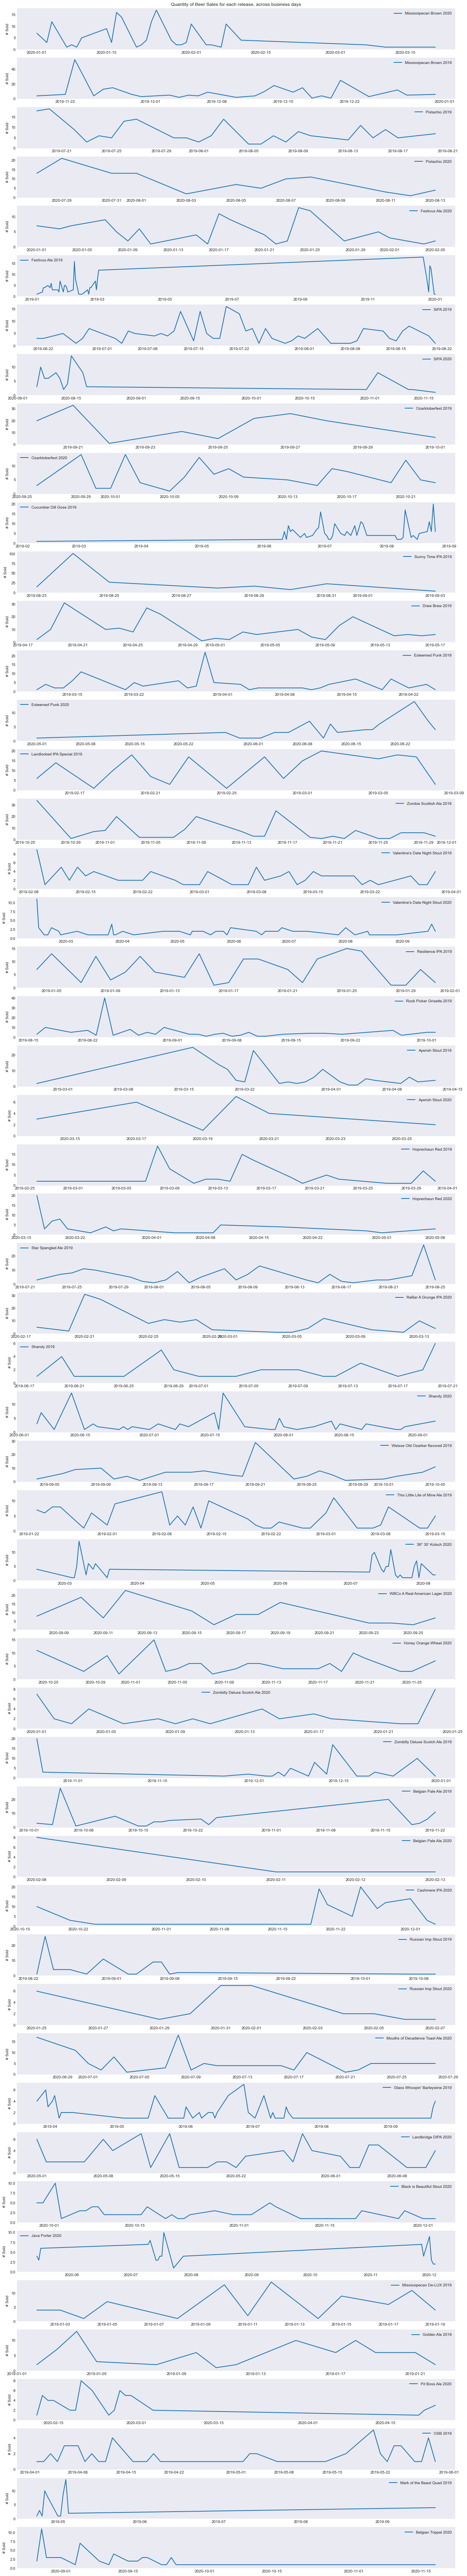

In [5]:
fig, ax = plt.subplots(len(beer_sales["name"].unique()),1, figsize=(20,3*len(beer_totals.index)))
i= 0
for beer in beer_sales["name"].unique():
    this_beer = beer_sales[beer_sales["name"] == beer]
    sales_by_hour = this_beer.groupby(this_beer["datetime_hour"].dt.date).sum()
    
    this_beer.head(2)
    ax[i].plot("Quantity", data=sales_by_hour, linewidth=2, alpha=1, label=beer)
    ax[i].set_ylabel("# Sold")
    ax[i].set_ylim(0)
    ax[i].legend()
    ax[0].set_title(f" ")

    i += 1

ax[0].set_title(f"Quantity of Beer Sales for each release, across business days")
fig.savefig("images/sales_series.jpg")
plt.show();

## Get a simple plot to see how the beers interact over time

#### Removing the beers that were off tap for long periods, also any that are on tap longer than 150 days

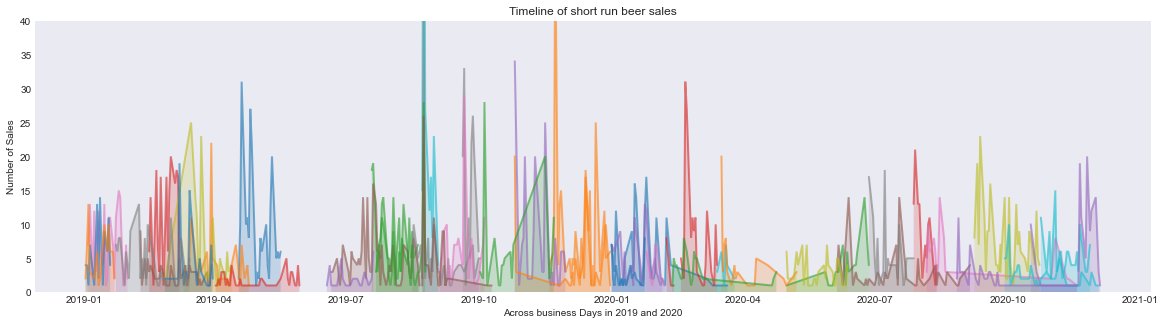

In [6]:
fig, ax = plt.subplots(1, figsize=(20,5))

for beer in beer_sales["name"].unique():

    this_beer = beer_sales[beer_sales["name"] == beer].copy()
    this_beer['day_ordinal'] = this_beer['datetime_hour'].apply(lambda x: x.toordinal())
    minimum_ord = this_beer['day_ordinal'].min()
    this_beer['day_ordinal_normalized'] = this_beer['day_ordinal']  - minimum_ord
    
    if this_beer['day_ordinal_normalized'].max() < 150:
        sales_by_hour = this_beer.groupby(this_beer["datetime_hour"].dt.date).sum()
        ax.plot(sales_by_hour.index, sales_by_hour['Quantity'], linewidth=2, alpha=.6, label=beer, solid_joinstyle="bevel")
        ax.fill_between(sales_by_hour.index, sales_by_hour['Quantity'], linewidth=0, alpha=.2, label=beer)

ax.set_title(f"Timeline of short run beer sales")
ax.set_ylim(0,40)
ax.set_ylabel("Number of Sales")
ax.set_xlabel("Across business Days in 2019 and 2020")
fig.savefig("images/sales_timeline.jpg")
plt.show();

## What happens if they all start on the same day?

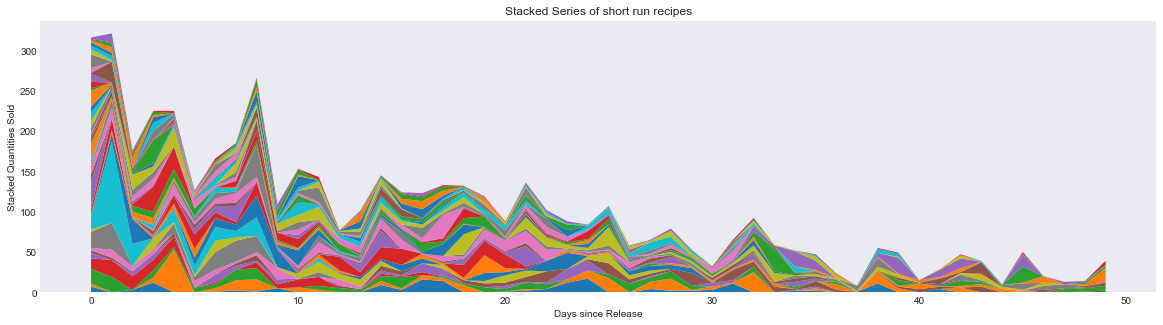

In [7]:
fig, ax = plt.subplots(1, figsize=(20,5))
max_list_size = 0
beer_series = []

for beer in beer_sales["name"].unique():

    this_beer = beer_sales[beer_sales["name"] == beer].copy()
    
    this_beer['day_ordinal'] = this_beer['datetime_hour'].apply(lambda x: x.toordinal())
    minimum_ord = this_beer['day_ordinal'].min()
    this_beer['day_ordinal_normalized'] = this_beer['day_ordinal']  - minimum_ord
    
    if this_beer['day_ordinal_normalized'].max() < 150:
        sales_by_day = this_beer.groupby([this_beer["day_ordinal_normalized"]]).sum()
        days_a = []
        for i in np.arange(0,150):
            if len(sales_by_day[sales_by_day.index == i]['Quantity']) == 0:
                days_a.append(0)
            else:
                days_a.append(sales_by_day[sales_by_day.index == i]['Quantity'].sum())

        beer_series.append(days_a[:50])
        
ax.stackplot(np.arange(0,50), *beer_series, linewidth=2, alpha=1, baseline='zero')

ax.set_title(f"Stacked Series of short run recipes")
ax.set_ylabel("Stacked Quantities Sold")
ax.set_xlabel("Days since Release")
fig.savefig("images/sales_stacked.jpg")
plt.show();

### What is the distribution of time on tap?

45


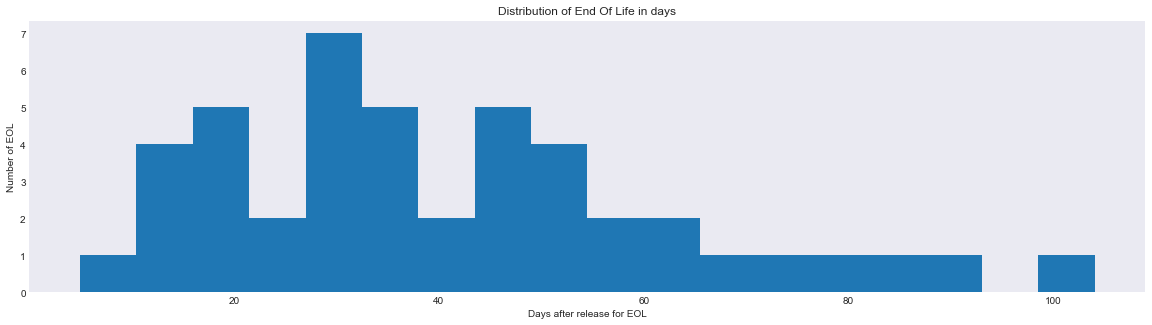

In [8]:
fig, ax = plt.subplots(1, figsize=(20,5))
max_list_size = 0
beer_series = []

for beer in beer_sales["name"].unique():

    this_beer = beer_sales[beer_sales["name"] == beer].copy()
    
    this_beer['day_ordinal'] = this_beer['datetime_hour'].apply(lambda x: x.toordinal())
    minimum_ord = this_beer['day_ordinal'].min()
    this_beer['day_ordinal_normalized'] = this_beer['day_ordinal']  - minimum_ord
    
    if this_beer['day_ordinal_normalized'].max() < 150:
        sales_by_day = this_beer.groupby([this_beer["day_ordinal_normalized"]]).sum()
        days_a = []
        max_day_sold = 0
        
        for i in np.arange(0,150):
            if len(sales_by_day[sales_by_day.index == i]['Quantity']) == 0:
                days_a.append(0)
            else:
                max_day_sold = i
                days_a.append(sales_by_day[sales_by_day.index == i]['Quantity'].sum())

        beer_series.append(max_day_sold)
        
    
        
ax.hist(beer_series, bins=18)

ax.set_title(f"Distribution of End Of Life in days")
ax.set_ylabel("Number of EOL")
ax.set_xlabel("Days after release for EOL")

print(len(beer_series))

fig.savefig("images/eol_hist.jpg")
plt.show();


### If we limit to similar life cycles

Text(0.5, 0, 'Days since Release')

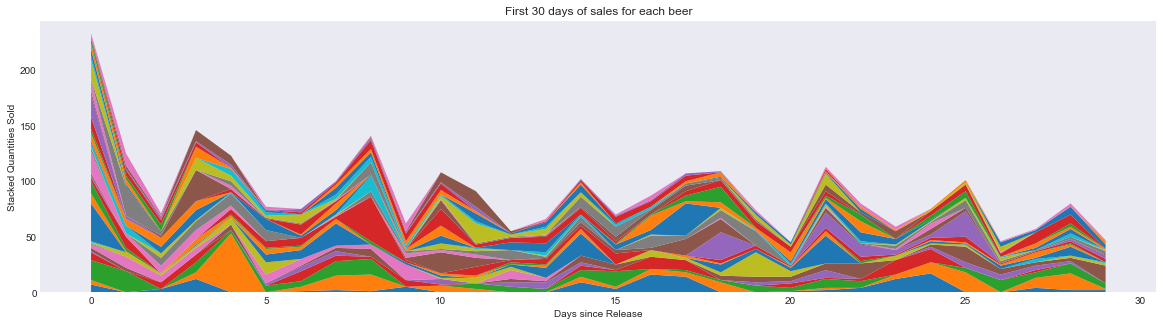

In [9]:
fig, ax = plt.subplots(1, figsize=(20,5))
max_list_size = 0
beer_series = []

for beer in beer_sales["name"].unique():

    this_beer = beer_sales[beer_sales["name"] == beer].copy()
    
    this_beer['day_ordinal'] = this_beer['datetime_hour'].apply(lambda x: x.toordinal())
    minimum_ord = this_beer['day_ordinal'].min()
    this_beer['day_ordinal_normalized'] = this_beer['day_ordinal']  - minimum_ord
    
    if this_beer['day_ordinal_normalized'].max() >= 30:
        sales_by_day = this_beer.groupby([this_beer["day_ordinal_normalized"]]).sum()
        days_a = []
        for i in np.arange(0,30):
            if len(sales_by_day[sales_by_day.index == i]['Quantity']) == 0:
                days_a.append(0)
            else:
                days_a.append(sales_by_day[sales_by_day.index == i]['Quantity'].sum())

        beer_series.append(days_a[:30])
        
ax.stackplot(np.arange(0,30), *beer_series, linewidth=2, alpha=1, baseline='zero')

ax.set_title(f"First 30 days of sales for each beer")
ax.set_ylabel("Stacked Quantities Sold")
ax.set_xlabel("Days since Release")


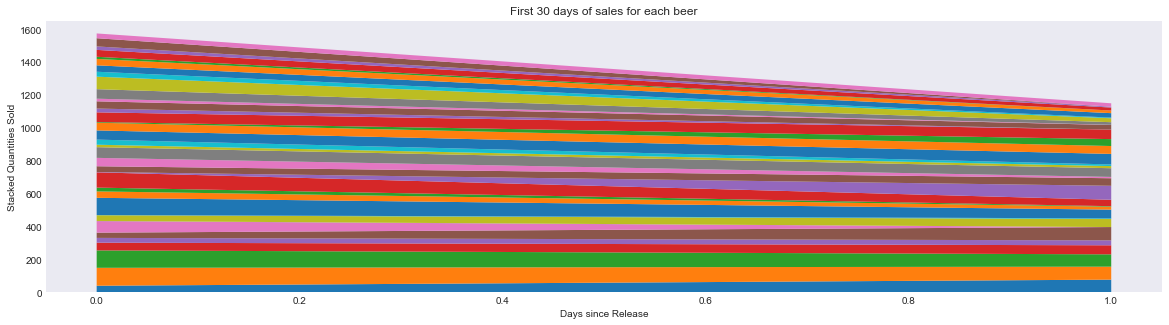

In [10]:
fig, ax = plt.subplots(1, figsize=(20,5))
max_list_size = 0
beer_series = []
q_series = []

for beer in beer_sales["name"].unique():

    this_beer = beer_sales[beer_sales["name"] == beer].copy()
    
    this_beer['day_ordinal'] = this_beer['datetime_hour'].apply(lambda x: x.toordinal())
    minimum_ord = this_beer['day_ordinal'].min()
    this_beer['day_ordinal_normalized'] = this_beer['day_ordinal']  - minimum_ord

    if this_beer['day_ordinal_normalized'].max() >= 30:
        sales_by_day = this_beer.groupby([this_beer["day_ordinal_normalized"]]).sum()
        days_a = []
        for i in np.arange(0,30):
            if len(sales_by_day[sales_by_day.index == i]['Quantity']) == 0:
                days_a.append(0)
            else:
                days_a.append(sales_by_day[sales_by_day.index == i]['Quantity'].sum())

        b1 = np.array(days_a[:15]).sum()
        b2 = np.array(days_a[15:30]).sum()
        q = [b1, b2]
        q_series.append(q)
        
        beer_series.append(days_a[:30])
        
ax.stackplot(np.arange(0,2), *q_series, linewidth=2, alpha=1, baseline='zero')

ax.set_title(f"First 30 days of sales for each beer")
ax.set_ylabel("Stacked Quantities Sold")
ax.set_xlabel("Days since Release")
fig.savefig("images/a_b_trend.jpg")
plt.show();

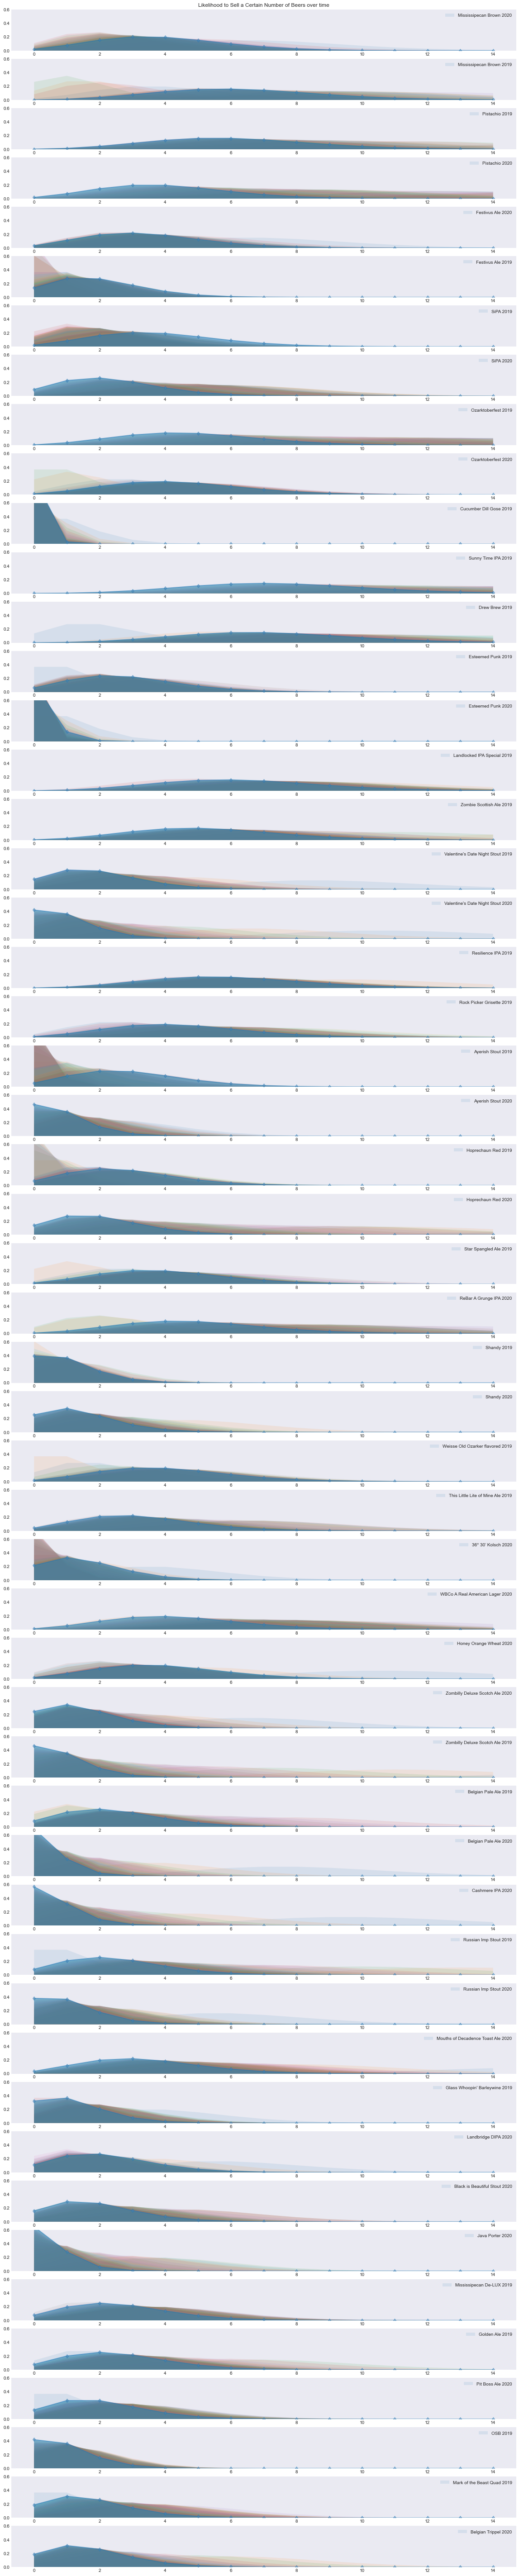

In [11]:
max_list_size = 0
beer_series = []
cutoff_days = 30
beer_count = 52

fig, ax = plt.subplots(beer_count, 1, figsize=(20,2*beer_count))

beer_counter = 0
for beer in beer_sales["name"].unique():

    this_beer = beer_sales[beer_sales["name"] == beer].copy()
    
    this_beer['day_ordinal'] = this_beer['datetime_hour'].apply(lambda x: x.toordinal())
    minimum_ord = this_beer['day_ordinal'].min()
    this_beer['day_ordinal_normalized'] = this_beer['day_ordinal']  - minimum_ord

    if this_beer['day_ordinal_normalized'].max() > 0:
        sales_by_day = this_beer.groupby([this_beer["day_ordinal_normalized"]]).sum()
        days_a = []
        for i in np.arange(0,cutoff_days):
            if len(sales_by_day[sales_by_day.index == i]['Quantity']) == 0:
                days_a.append(0)
            else:
                days_a.append(sales_by_day[sales_by_day.index == i]['Quantity'].sum())

                
            poisson_mu = np.array(days_a).mean()    
            dist = stats.poisson(mu=poisson_mu)
            support = np.arange(0,15)
            ax[beer_counter].fill_between(support, dist.pmf(support), linewidth=0, alpha=.1)
            ax[beer_counter].legend([beer])

        poisson_mu = np.array(days_a).mean()    
        dist = stats.poisson(mu=poisson_mu)
        support = np.arange(0,15)
        ax[beer_counter].fill_between(support, dist.pmf(support), linewidth=0, alpha=.5)
        ax[beer_counter].plot(support, dist.pmf(support), linewidth=2, alpha=.5, label=beer, marker="d", markerfacecolor='steelblue', markersize=6)
        ax[beer_counter].set_ylim(0,.6)

        beer_counter += 1
ax[0].set_title(f"Likelihood to Sell a Certain Number of Beers over time");

fig.savefig("images/poisson_shadow.jpg")
plt.show();


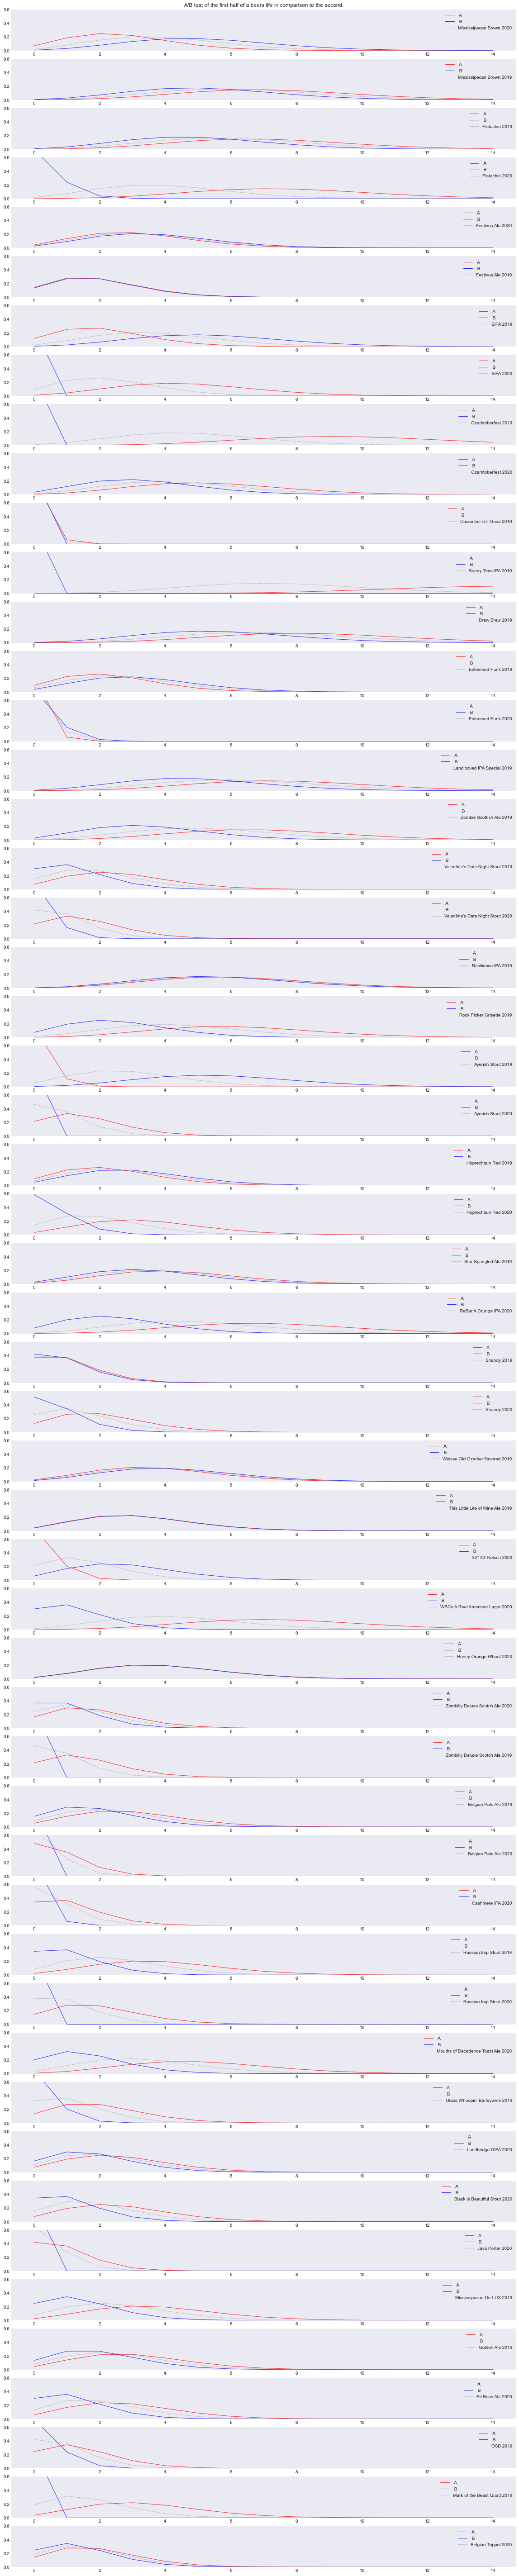

In [12]:
max_list_size = 0
beer_series = []
cutoff_days = 30
beer_count = 52

fig, ax = plt.subplots(beer_count, 1, figsize=(20,2*beer_count))

beer_counter = 0
for beer in beer_sales["name"].unique():

    this_beer = beer_sales[beer_sales["name"] == beer].copy()
    
    this_beer['day_ordinal'] = this_beer['datetime_hour'].apply(lambda x: x.toordinal())
    minimum_ord = this_beer['day_ordinal'].min()
    this_beer['day_ordinal_normalized'] = this_beer['day_ordinal']  - minimum_ord

    if this_beer['day_ordinal_normalized'].max() > 0:
        sales_by_day = this_beer.groupby([this_beer["day_ordinal_normalized"]]).sum()
        days_a = []
        for i in np.arange(0,cutoff_days):
            if len(sales_by_day[sales_by_day.index == i]['Quantity']) == 0:
                days_a.append(0)
            else:
                days_a.append(sales_by_day[sales_by_day.index == i]['Quantity'].sum())

        split_place = int(len(days_a)/2)
        a = days_a[:split_place]
        b = days_a[split_place:]
        poisson_mu = np.array(days_a).mean()   
        a_mu = np.array(a).mean()
        b_mu = np.array(b).mean()
        
        dist = stats.poisson(mu=poisson_mu)
        a_dist = stats.poisson(mu=a_mu)
        b_dist = stats.poisson(mu=b_mu)
        support = np.arange(0,15)

        ax[beer_counter].plot(support, a_dist.pmf(support), linewidth=1, alpha=.8, label=f" A ", color="red")
        ax[beer_counter].plot(support, b_dist.pmf(support), linewidth=1, alpha=.8, label=f" B ", color="blue")
        
        ax[beer_counter].plot(support, dist.pmf(support), linewidth=1, alpha=.5, label=f"{beer}", linestyle="--", color="grey")
        ax[beer_counter].set_ylim(0,.6)
        ax[beer_counter].legend()

        beer_counter += 1
ax[0].set_title(f"A/B test of the first half of a beers life in comparison to the second.");
  

## Statistical Power

## Single tailed test to see if the second two weeks is better. Our confidence interval is 90%

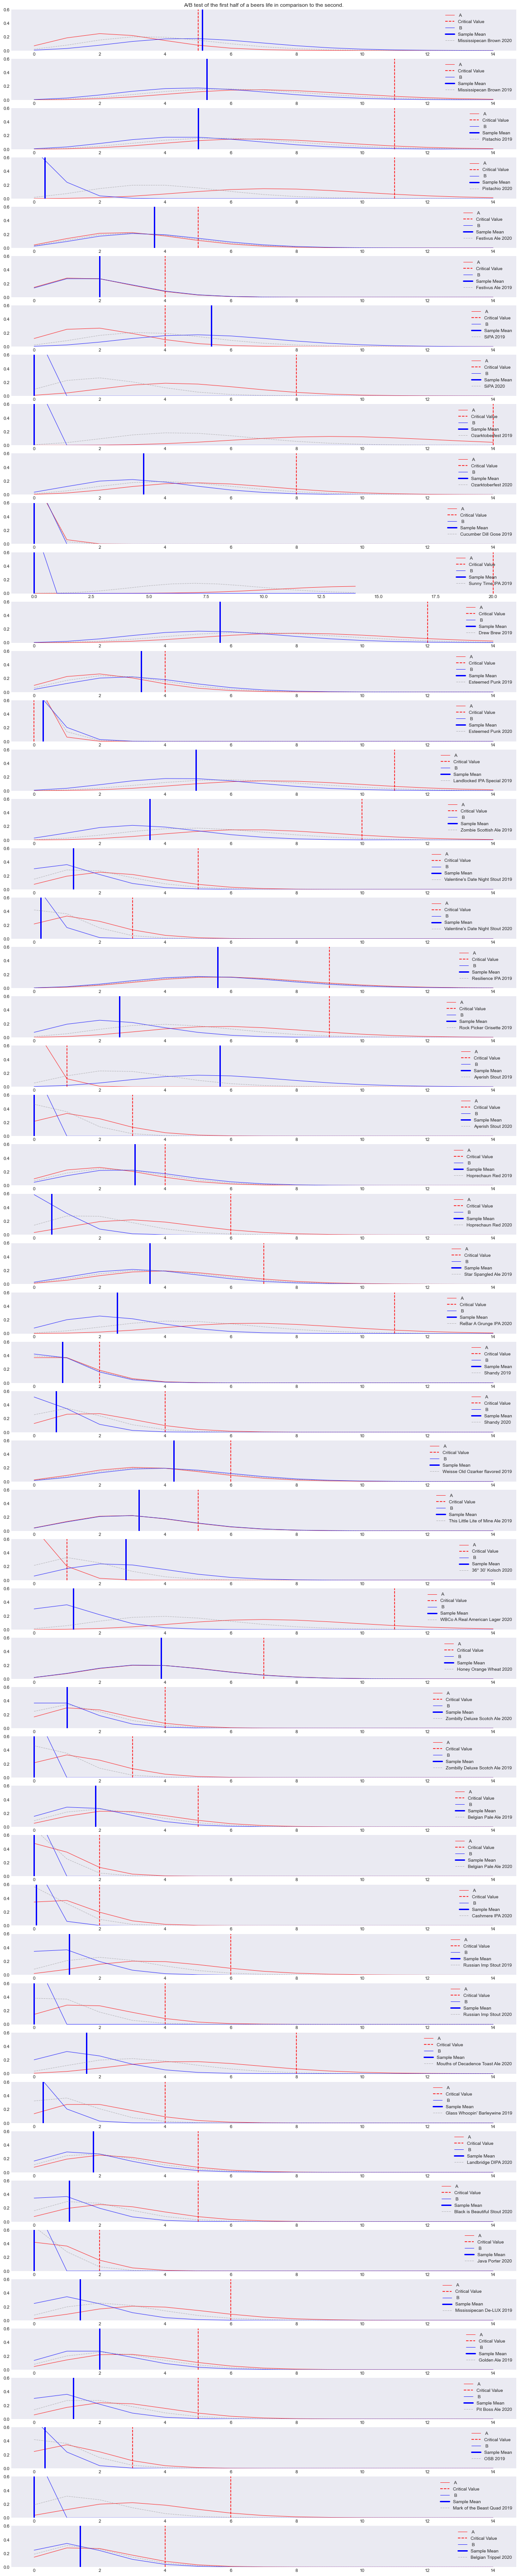

In [13]:
max_list_size = 0
beer_series = []
cutoff_days = 30
beer_count = 52

fig, ax = plt.subplots(beer_count, 1, figsize=(20,2*beer_count))

beer_counter = 0
for beer in beer_sales["name"].unique():

    this_beer = beer_sales[beer_sales["name"] == beer].copy()
    
    this_beer['day_ordinal'] = this_beer['datetime_hour'].apply(lambda x: x.toordinal())
    minimum_ord = this_beer['day_ordinal'].min()
    this_beer['day_ordinal_normalized'] = this_beer['day_ordinal']  - minimum_ord

    if this_beer['day_ordinal_normalized'].max() > 0:
        sales_by_day = this_beer.groupby([this_beer["day_ordinal_normalized"]]).sum()
        days_a = []
        for i in np.arange(0,cutoff_days):
            if len(sales_by_day[sales_by_day.index == i]['Quantity']) == 0:
                days_a.append(0)
            else:
                days_a.append(sales_by_day[sales_by_day.index == i]['Quantity'].sum())

        split_place = int(len(days_a)/2)
        a = days_a[:split_place]
        b = days_a[split_place:]
        poisson_mu = np.array(days_a).mean()   
        a_mu = np.array(a).mean()
        b_mu = np.array(b).mean()
        
        dist = stats.poisson(mu=poisson_mu)
        a_dist = stats.poisson(mu=a_mu)
        b_dist = stats.poisson(mu=b_mu)
        
        high_err = a_dist.ppf(1-0.1)

        support = np.arange(0,15)

        ax[beer_counter].plot(support, a_dist.pmf(support), linewidth=1, alpha=.8, label=f" A ", color="red")
        ax[beer_counter].axvline(high_err, color="red", linestyle="--", label="Critical Value")

        ax[beer_counter].plot(support, b_dist.pmf(support), linewidth=1, alpha=.8, label=f" B ", color="blue")
        ax[beer_counter].axvline(b_mu, color="blue", linewidth=3, label="Sample Mean")

        ax[beer_counter].plot(support, dist.pmf(support), linewidth=1, alpha=.5, label=f"{beer}", linestyle="--", color="grey")
        ax[beer_counter].set_ylim(0,.6)
        ax[beer_counter].legend()

        beer_counter += 1
        
    
ax[0].set_title(f"A/B test of the first half of a beers life in comparison to the second.");
fig.savefig("images/poisson_crits.jpg")
plt.show();